In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation
plt.rcParams['animation.ffmpeg_path'] = '/home/nathan.meulenbroek/miniconda3/bin'
libraries_installed = False
import scipy.optimize as root_find
%matplotlib inline

In [2]:
def make_plot(title='', x_label='', y_label='', z_label='', x_lim=(0, 0), y_lim=(0,0), z_lim=(0,0), 
              grid=True, size=(6, 4), dpi=115, three_d=False):
    '''
    Generates a plot object
    
    Parameters:
        title - (string) title of the plot
        x - (float) a list of values for omega/omega_0
        y - (float) a list of values for the amplitude
        xlim - (float) the limit for the x axis, this is a list containing 2 variables, 
                    the max and min value of x
        ylim - (float) the limit for the y axis, this is a list containing 2 variables, 
                    the max and min value of y
        size - (int) resizing the figure of the plot
        dpi - (int) increasing the quality of the image produced
    Returns:
        plot - (object) the plot
    '''
    fig = plt.figure(figsize=(size[0], size[1]), dpi=dpi)
    plot = fig.add_subplot(111) if not three_d else fig.add_subplot(111, projection='3d')
    
    plot.set_title(title)
    if y_lim[0] != 0 and y_lim[1] !=0: plot.set_ylim(y_lim[0], y_lim[1])
    if x_lim[0] != 0 and x_lim[1] !=0: plot.set_xlim(x_lim[0], x_lim[1])
    if z_lim[0] != 0 and z_lim[1] !=0: plot.set_zlim(z_lim[0], z_lim[1])
    plot.set_xlabel(x_label)
    plot.set_ylabel(y_label)
    if three_d: plot.set_zlabel(z_label)
    if grid: plt.grid()
    
    return plot

## 4 Simulated Annealing

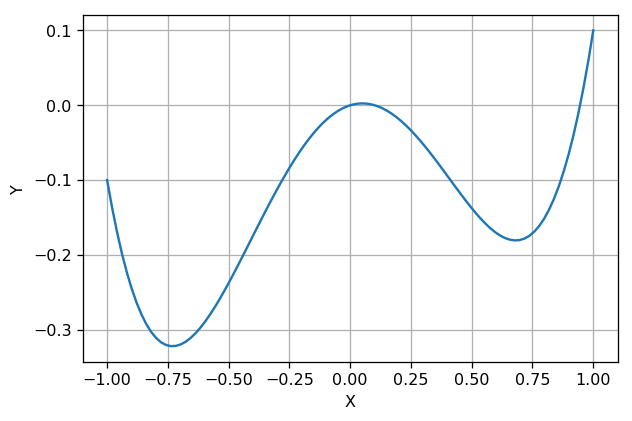

In [3]:
def double_well(x):
    '''
    Double well function for examples.
    
    Params:
        x - (float) point at which to evaluate function
    Returns:
        - (float) value at given point
    ''' 
    return x**4-x**2+0.1*x

x = np.linspace(-1,1,100)
make_plot(x_label="X", y_label="Y").plot(x, double_well(x));

To optimize this function manually, and find theoretical values to check against the simulated annealing algorithm, we take the derivative and find the zeros:

$$\frac{d}{dx}(x^4-x^2+0.1x)=4x^3-2x+0.1=0$$

In [4]:
def derivative_double_well(x):
    '''
    Derivative of double well function for rootfinding purposes.
    
    Params:
        x - (float) point at which to evaluate derivative
    Returns:
        - (float) value at given point
    ''' 
    return 4*x**3-2*x+0.1

min1 = root_find.brentq(derivative_double_well, -0.75, -0.5)
min2 = root_find.brentq(derivative_double_well, 0.5, 0.75)
print("Global minima of value y =", double_well(min1), "at point x =", min1)
print("Local minima of value y =", double_well(min2), "at point x =", min2)

Global minima of value y = -0.3219193468815589 at point x = -0.7308931031862202
Local minima of value y = -0.18058696657349232 at point x = 0.6806392764236684


In [5]:
def geometric_temp_schedule(t, n, T_0, T_f):
    '''
    Geometric temperature schedule for simulated annealing algorithms
    
    Params:
        t - (float) Time, or number of steps, at current iteration
        n - (float) Total time or number of steps being taken  
        T_0 - (float) Initial temperature
        T_f - (float) Final temperature
    Returns:
        - (float) Temperature at this point in time
    ''' 
    return np.maximum(T_0*np.power(T_f/T_0, t/n), T_f)

def wrap_boundaries(position, xlims, x_period, ylims, y_period):
    '''
    Wraps the boundaries for specified boundary conditions
    
    Params:
        position - (tuple) x and y coordinates of position. None if no limits.
        xlims - (tuple) Max and min of x interval 
        x_period - (float) Length of x interval
        ylims - (tuple) Max and min of y interval
        x_period - (float) Length of y interval
    Returns:
        position - (tuple) Wrapped x values
    ''' 
    if xlims != None: 
        temp_x = position[0] - xlims[0]
        temp_x = temp_x % x_period
        position[0] = temp_x + xlims[1] if temp_x < 0 else temp_x + xlims[0]
        
    if ylims != None: 
        temp_y = position[1] - ylims[0]
        temp_y = temp_y % y_period
        position[1] = temp_y + ylims[1] if temp_y < 0 else temp_y + ylims[0]
    
    return position

def coin_flip_sa(current_cost, T):
    '''
    Randomly returns true or false based on the ratio of a cost to temperature
    
    Params:
        current_cost - (float) Current cost value of a function
        T - (float) Current temperature of the system
    Returns:
        - (bool) Random decision
    ''' 
    return np.random.random() < np.exp(current_cost/T)

def simulated_annealing(fn, T_0=100, T_f=1e-9, temp_schedule_fn=geometric_temp_schedule,
                           initial_pos=(0,0), nsweeps=100, nsteps=100, searching_for='maxima',
                           distribution=np.random.randn, dist_args=(), xlims=None, ylims=None,
                           verbose=False):
    '''
    Simulated annealing method to find the maxima or minima of an arbitrary function.
    
    Params:
        fn - (function) Arbitrary function to optimise
        T_0 - (float) Optional. Initial temperature of the system
        T_f - (float) Optional. Final temperature of the system
        temp_schedule_fn - (Function) Optional. Temperature schedule
        initial_pos - (tuple) Optional. Inital position in function
        nsweeps - (int) Optional. Number of sweeps at each temperature
        nsteps - (int) Optional. Number of steps with new temperatures
        searching_for - (string) Optional. Switch to find max or min.
        xlims - (tuple) Optional. X limits of search range
        ylims - (tuple) Optional. Y limits of search range
        verbose - (bool) Optional. Set to true to also return positions
    Returns:
        pos - (tuple) Best solution as found after cooling
    ''' 
    # Flip function values if looking for a minimum
    optimization_multiplier = -1 if searching_for == 'maxima' else 1
    # The function is our cost function
    cost = fn(*initial_pos)*optimization_multiplier
    pos = initial_pos
    T = T_0
    x_period = xlims[1]-xlims[0] if xlims != None else 0
    y_period = ylims[1]-ylims[0] if ylims != None else 0
    if verbose: positions = []
    
    for i in range(nsteps):
        for j in range(nsweeps):
            # Generate random position to check
            temp_pos = list(wrap_boundaries(pos + distribution(*dist_args, np.size(initial_pos)), xlims, x_period, ylims, y_period))
            temp_cost = fn(*temp_pos)*optimization_multiplier
            
            # If an obviously good choice or by coin flip, update position and min cost
            if (temp_cost <= cost) or coin_flip_sa(cost-temp_cost, T):
                pos = temp_pos
                cost = temp_cost
                if verbose: positions.append(pos)
                
        # Cool temperature
        T = temp_schedule_fn(i, nsteps, T_0, T_f)
        
    if verbose:
        return pos, np.array(positions).flatten()
    else:
        return pos
    
def sm_plot(positions, font_size=22):
    '''
    Quick plot function for 2-panel figure as described in assignment.
    
    Params:
        positions - (float) Time, or number of steps, at current iteration
    ''' 
    
    f,ax = plt.subplots(1,2, figsize=(12,8))
    
    ax[0].plot(range(len(positions)), positions, 'o-', linewidth=1, markersize=2, markerfacecolor='red', markeredgecolor='red')
    ax[0].set_xlabel("Step", fontsize=font_size)
    ax[0].set_ylabel("X Position", fontsize=font_size)
    ax[0].set_title('Time Series of Walkers\' Positions', fontsize=font_size)
    ax[0].invert_yaxis()
    ax[0].grid('on')
    
    ax[1].hist(positions, color="#ffb759", ec='black', bins=50)
    ax[1].set_xlabel("Positions", fontsize=font_size)
    ax[1].set_ylabel("Number of Occurences", fontsize=font_size)
    ax[1].set_title('Histogram of Walkers\' Positions', fontsize=font_size)
    ax[1].grid('on')
    
    plt.tight_layout()
    return

0.884256276862


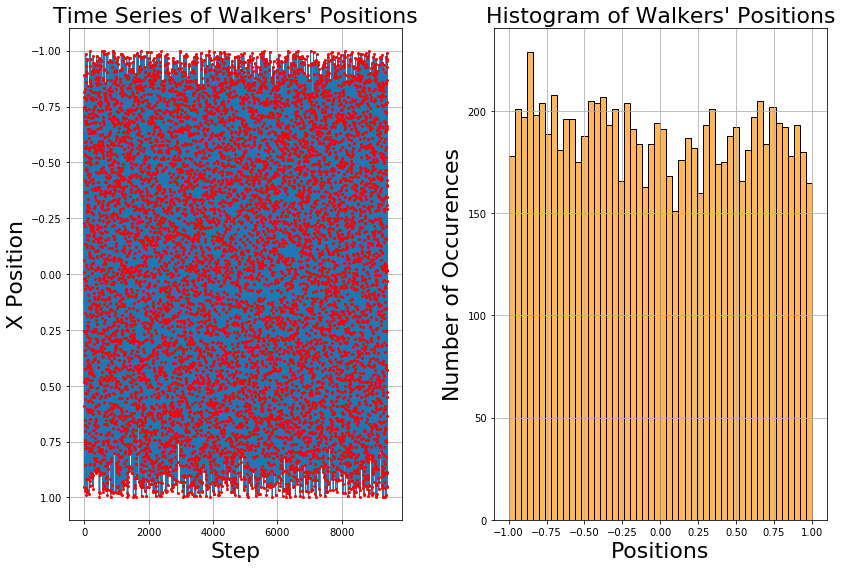

In [6]:
T=1
optimum, positions = simulated_annealing(double_well, initial_pos=[0], xlims=(-1,1), T_0=T, T_f=T, 
                                          distribution=np.random.uniform, dist_args=[-1,1], 
                                          searching_for='minima', verbose=True)
print(*optimum)
sm_plot(positions)

0.786235780181


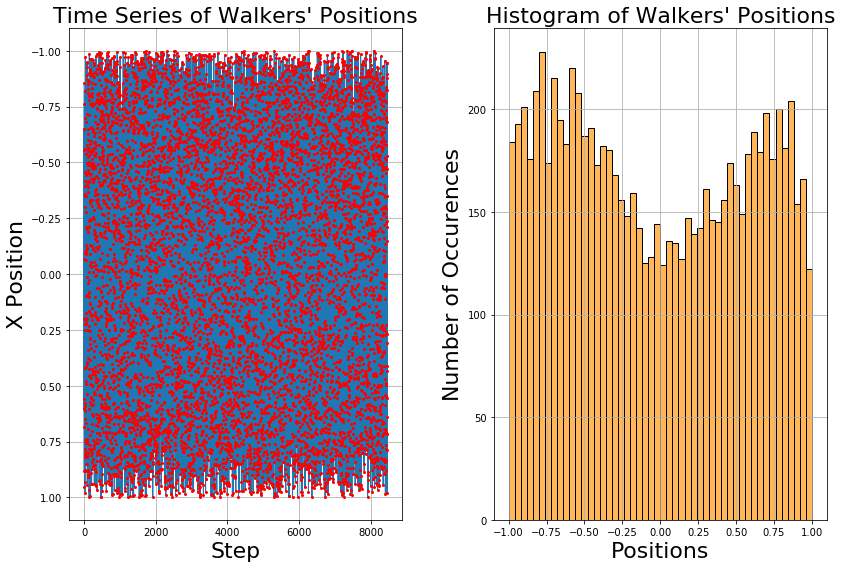

In [7]:
T=0.4
optimum, positions = simulated_annealing(double_well, initial_pos=[0], xlims=(-1,1), T_0=T, T_f=T, 
                                          distribution=np.random.uniform, dist_args=[-1,1], 
                                          searching_for='minima', verbose=True)
print(*optimum)
sm_plot(positions)

0.361550233858


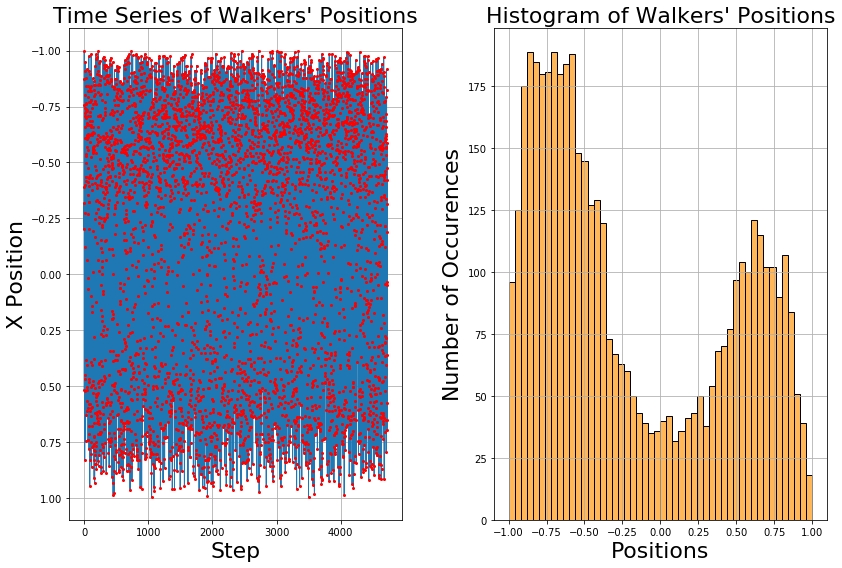

In [8]:
T=0.1
optimum, positions = simulated_annealing(double_well, initial_pos=[0], xlims=(-1,1), T_0=T, T_f=T, 
                                          distribution=np.random.uniform, dist_args=[-1,1], 
                                          searching_for='minima', verbose=True)
print(*optimum)
sm_plot(positions)

-0.731351974421


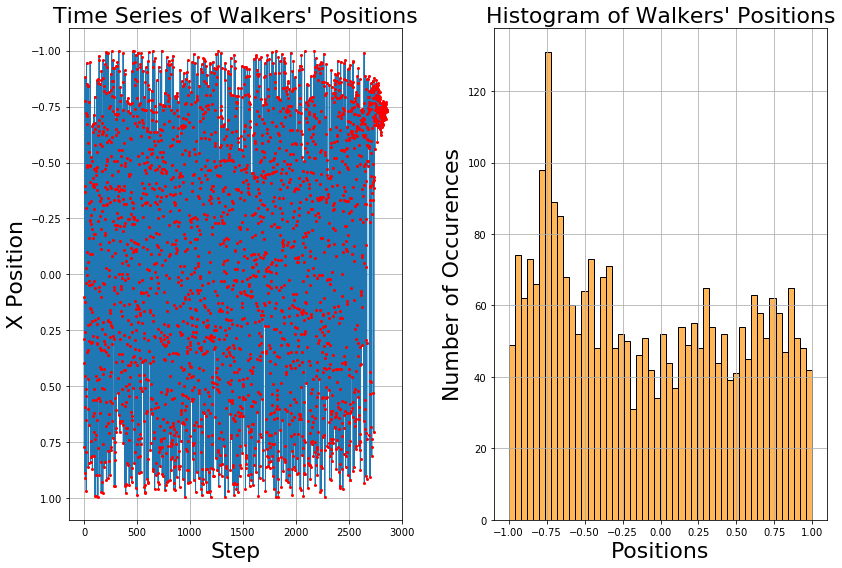

In [9]:
optimum, positions = simulated_annealing(double_well, initial_pos=[0], xlims=(-1,1),
                                          distribution=np.random.uniform, dist_args=[-1,1], 
                                          searching_for='minima', verbose=True)
print(*optimum)
sm_plot(positions)

Where the temperature is at $T=1$, we see that the walker is free to move nearly anywhere. The histogram does show a slight tendency towards staying in the minima, but this is not really visible to the naked eye when looking at the time series. These results are results are consistent with the uniform distribution we're sampling from. With the temperature set to be high, all of the random jumps have a high probability of being accepted. When running the simulation multiple times, this temperature at which there is the highest variance between the returned optimum. 

At $T=0.4$, we can see that the distribution is more similar to the original function, with peaks around the general locations of the local minima in the histogram. The time series plot appears to have some weighting towards this distribution as well, but the pattern is not very perceptible. 

Once we drop to $T=0.1$, the pattern that we saw is more perceptible. The histrogram is similar to a reflection alond the x axis of the original function, and the time series representation is obviously more biased to the larger local optimum. We can still see that, even though the walker is biased to that region, it's still able to jump out of the minima often enough to roam around the function to find other minima as well.

With a proper temperature schedule, we see a mixture of all of the above. The distribution in the histogram is more flat overall, but has a large spike in the local maximum. The time series representation very clearly shows how the function gets stuck in the glabal minimum towards the end of the steps being taken. Overall, the gradual decrease in temperature allowed the walker to slowly hone in on the true global minimu, while still being able to travel enough to not get stuck in the other, local minimum. The temperature schedule also required the fewest number of points, something which speaks well for the runtime.

## 4.1 The travelling Salesman (TSP) route optimization

In [10]:
def recursive_iteration(element, indexes, points, tour, cost_fn, min_cost, min_tour, verbose=False):
    '''
    Protected recursive method to iterate through all of the possible state
    values for a tour of the specified points.
    
    Params:
        element - (int) Element of state which we're changing
        indexes - (array-like) Available indexes to choose from
        points - (array-like) List of city coordinates
        tour - (array-like) The order which we're visiting the cities in
        cost_fn - (function) Cost function to benchmark results.
        min_cost - (float) Current lowest cost
        min_tour - (array-like) Corresponding lowest cost tour
        verbose - (bool) Optional. Set to true to return frames in progress
    Returns:
        min_cost - (float) Best solution cost as found after cooling.
                            Needed for communication between recursive calls
        min_tour - (array-like) Best solution as found after cooling.
    ''' 
    if verbose: frames = []
    for j, i in enumerate(indexes):
        tour[element] = i # Set current element to a certain 
        
        if element == len(points) - 1:
            # Only if we have a complete state, check solution against best recorded
            temp_cost = cost_fn(points, tour)
            
            if verbose: frames.append(points[tour])
            
            if temp_cost < min_cost:
                min_cost = temp_cost
                min_tour = list(tour)
                
        else:
            # If we're not at the end yet, do a depth first approach towards valid solns.
            # Also, mask out the indexes element that we've just used so that we don't
            # go to the same city twice
            index_mask = np.ones(len(indexes), dtype=bool)
            index_mask[j] = 0
            
            if verbose: 
                # Go to the next recursive step
                min_cost, min_tour, temp_frames = recursive_iteration(element+1, indexes[index_mask], 
                                                                      points, list(tour), cost_fn, min_cost, 
                                                                      min_tour, verbose=True)
                frames.extend(temp_frames)
            else:
                min_cost, min_tour = recursive_iteration(element+1, indexes[index_mask], points, list(tour), 
                                                         cost_fn, min_cost, min_tour)
    
    # When all choices have been made at this depth, pop back up one step and go to the next iteration
    if verbose:
        return min_cost, min_tour, frames
    else:
        return min_cost, min_tour

def brute_force_path_optimization(points, cost_fn, verbose=False):
    '''
    Recursive method controller to iterate through all possible tour states.
    
    Params:
        points - (array-like) Points in question to optimize the route
        cost_fn - (function) Function that determines the worth of a state
        verbose - (bool) Optional. Set to true to return frames from progress
    Returns:
        min_tour - (array-like) Best solution
    '''
    tour = np.zeros(len(points) + 1, dtype=int) # Initial tour
    indexes = np.arange(1, len(points)) # Available city indexes
    current_cost = cost_fn(points, tour) # Current cost
    
    # Initial values for best tour
    min_tour = np.append(np.arange(len(points)), 0)
    min_cost = cost_fn(points, min_tour)
     
    if verbose:
        min_cost, min_tour, frames = recursive_iteration(1, indexes, points, list(tour), cost_fn, min_cost, min_tour, verbose=True)  
        return min_tour, frames
    else:
        min_cost, min_tour = recursive_iteration(1, indexes, points, list(tour), cost_fn, min_cost, min_tour) 
        return min_tour

In [11]:
def geometric_temp_schedule(t, n, T_0, T_f):
    '''
    Geometric temperature schedule for simulated annealing algorithms
    
    Params:
        t - (float) Time, or number of steps, at current iteration
        n - (float) Total time or number of steps being taken  
        T_0 - (float) Initial temperature
        T_f - (float) Final temperature
    Returns:
        - (float) Temperature at this point in time
    ''' 
    return np.maximum(T_0*np.power(T_f/T_0, t/n), T_f)

def random_tour_swap(tour):
    '''
    Randomly swaps any two states with equal probabilities
    
    Params:
        tour - (array-like) current solution to the problem
    Returns:
        temp_tour - (array-like) solution with two randomly swapped values
    '''
    temp_tour = tour[:]
    index1, index2 = np.random.choice(np.arange(tour.size)[1:-1], 2)
    temp_tour[index1], temp_tour[index2] = temp_tour[index2], temp_tour[index1]
    return temp_tour

def coin_flip_tsp(current_cost, next_cost, T):
    '''
    Coin flip function for disadvatageous moves
    
    Params:
        current_cost - (float) Current cost of solution
        next_cost - (float) Cost of temp solution
        T - (float) Current temperature of the system
    Returns:
        - (bool) True if accepted
    '''
    return np.random.random() < np.exp(-(next_cost-current_cost)/T)

def distance_cost(points, tour):
    '''
    Determines cost of a solution by the length of a path
    
    Params:
        points - (array-like) City coordinates
        tour - (array-like) Current solution
    Returns:
        cost - (float) sum of path length
    '''
    temp_tour = np.roll(tour, -1)
    temp = (points[tour, 0] - points[temp_tour, 0])**2
    temp1 = (points[tour, 1] - points[temp_tour, 1])**2
    cost = np.sum(np.sqrt(temp+temp1))
    return cost
    
def simulated_annealing_optimization(points, cost_fn, T_0=0.1, T_f=0.0001, 
                        temp_schedule_fn=geometric_temp_schedule, 
                        nsteps=100, nsweeps=10, verbose=False):
    '''
    Simulated annealing optimization function. Runs a temperature schedule
    to hone in on the best solution using random swaps
    
    Assumes that first city in the list is the 'home' city.
    
    Params:
        points - (array-like) City coordinates
        cost_fn - (function) Arbitrary function to optimise
        T_0 - (float) Optional. Initial temperature of the system
        T_f - (float) Optional. Final temperature of the system
        temp_schedule_fn - (Function) Optional. Temperature schedule
        nsteps - (int) Optional. Number temperatures
        nsweeps - (int) Optional. Number of sweeps at each temperature
        verbose - (bool) Optional. Set to true to also return frames
    Returns:
        min_tour - (array-like) Best solution as found after cooling
    '''
    T = T_0
    tour = np.append(np.arange(points.shape[0]), 0) # Initial tour
    current_cost = cost_fn(points, tour)
    if verbose: frames = []
    
    min_cost = cost_fn(points, tour)
    min_tour = tour[:]
    
    for i in range(1, nsteps+1):
        for i in range(nsweeps):
            # Randomly test new solution
            temp_tour = random_tour_swap(tour)
            temp_cost = cost_fn(points, temp_tour)
            
            if temp_cost < current_cost:
                # if solution is obviously better, accept it
                current_cost = temp_cost
                tour = temp_tour
                
                if verbose: frames.append(points[tour])
                
                # save the best case, since it's easy to jump away with this function
                if temp_cost < min_cost:
                    min_cost = temp_cost
                    min_tour = list(temp_tour)

            elif coin_flip_tsp(current_cost, temp_cost, T):
                # if solution is not better, decide whether to accept it
                current_cost = temp_cost
                tour = temp_tour
                if verbose: frames.append(points[tour])
        
        # lower temperature ever step
        T = temp_schedule_fn(i, nsteps, T_0, T_f)
        
    if verbose:
        return min_tour, frames
    else:
        return min_tour

In [12]:
def greedy_optimization(points, cost_fn, verbose=False):
    '''
    Greedy optimization algorithm which always takes the point which is the closest next.
    
    Params:
        points - (array-like) City coordinates
        cost_fn - (function) Method defining state value
        verbose - (bool) Optional. Set to true to also return frames
    Returns:
        tour - (array-like) Solution found
    '''
    unused_points_mask = np.ones(len(points), dtype=bool)
    unused_points_mask[0] = 0
    indexes = np.arange(len(points))
    tour = np.zeros(len(points), dtype=int)
    if verbose: frames = []
    
    for i in range(1, len(points)):
        temp_tour = list(tour) # copy list to avoid aliasing
        temp_tour[i] = indexes[unused_points_mask][0] # grab first available index
        best_cost = cost_fn(points, temp_tour)
        best_point = 0
        
        if verbose: frames.append(points[temp_tour])
        
        # Search for closest point among those available        
        for j in range(1, len(indexes[unused_points_mask])-1):
            temp_tour[i] = indexes[unused_points_mask][j]

            if cost_fn(points, temp_tour) < best_cost:
                best_point = j
        
        # Make the best point official, mark it as unavailable, and move on to next iteration
        tour[i] = indexes[unused_points_mask][best_point]
        unused_points_mask[indexes[unused_points_mask][best_point]] = False
        
    # Guarantee a round trip
    tour = np.append(tour, 0)
    if verbose:
        frames.append(points[tour])
        frames = np.array(frames)
        return tour, frames
    else:
        return tour

In [13]:
def bnb_recursive_iteration(element, indexes, points, tour, cost_fn, min_cost, min_tour):
    '''
    Branch and bound method of solving this. Extremely similar to brute force.
    In hindsight, not the best suited solution to this problem, but still works just fine.
    
    Params:
        element - (int) Element of state which we're changing
        indexes - (array-like) Available indexes to choose from
        points - (array-like) List of city coordinates
        tour - (array-like) The order which we're visiting the cities in
        cost_fn - (function) Cost function to benchmark results.
        min_cost - (float) Current lowest cost
        min_tour - (array-like) Corresponding lowest cost tour
        verbose - (bool) Optional. Set to true to return frames in progress
    Returns:
        min_cost - (float) Best solution cost as found after cooling.
                            Needed for communication between recursive calls
        min_tour - (array-like) Best solution as found after cooling.
    ''' 
    for j, i in enumerate(indexes):
        tour[element] = i
        temp_cost = cost_fn(points, tour)

        if element == len(points) - 1:
            # Only do solution comparison with a valid, full state
            if temp_cost < min_cost:
                min_cost = temp_cost
                min_tour = list(tour)
        else:
            # The key to branch and bound. Trim branches that are obviously bad.
            if temp_cost > min_cost:
                continue
            
            index_mask = np.ones(len(indexes), dtype=bool)
            index_mask[j] = 0
            min_cost, min_tour = recursive_iteration(element+1, indexes[index_mask], points, list(tour), cost_fn, min_cost, min_tour)
    
    return min_cost, min_tour

def branch_and_bound_path_optimization(points, cost_fn):
    '''
    Recursive method controller to iterate through state tree for
    branch and bound solution.
    
    Params:
        points - (array-like) Points in question to optimize the route
        cost_fn - (function) Function that determines the worth of a state
    Returns:
        min_tour - (array-like) Best solution
    '''
    tour = np.zeros(len(points) + 1, dtype=int) # Initial tour
    indexes = np.arange(1, len(points))
    current_cost = cost_fn(points, tour)
    
    min_tour = np.append(np.arange(len(points)), 0)
    min_cost = cost_fn(points, min_tour)
    
    # Start recursion with best solution seed (to avoid a depth first search for a valid solution)
    min_cost, min_tour = bnb_recursive_iteration(1, indexes, points, list(tour), cost_fn, min_cost, min_tour)  
    
    return min_tour

C: 2.68144514741


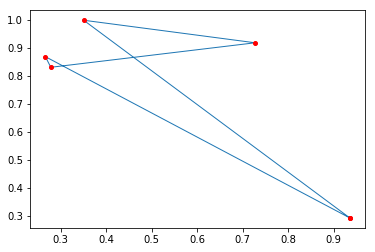

C: 2.08786901327


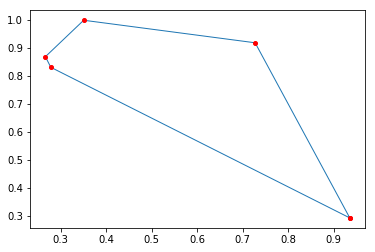

In [14]:
%matplotlib inline

npoints = 5
points = np.random.rand(npoints, 2)
tour = np.append(np.arange(points.shape[0]), 0)
print("C:", distance_cost(points, tour))
x, y = points[tour, 0], points[tour, 1]
plt.plot(x, y, 'o-', linewidth=1, markersize=4, markerfacecolor='red', markeredgecolor='red')
plt.show()

tour = branch_and_bound_path_optimization(points, distance_cost)
print("C:", distance_cost(points, tour))

x, y = points[tour, 0], points[tour, 1]
plt.plot(x, y, 'o-', linewidth=1, markersize=4, markerfacecolor='red', markeredgecolor='red');

C: 4.80879249256


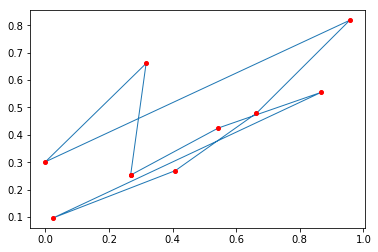

C: 2.6075200344


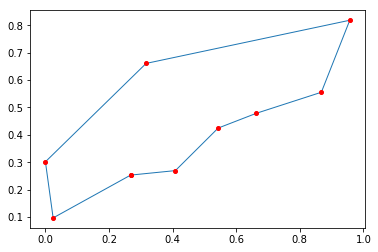

In [15]:
%matplotlib inline

npoints = 9
points = np.random.rand(npoints, 2)
tour = np.append(np.arange(points.shape[0]), 0)
print("C:", distance_cost(points, tour))
x, y = points[tour, 0], points[tour, 1]
plt.plot(x, y, 'o-', linewidth=1, markersize=4, markerfacecolor='red', markeredgecolor='red')
plt.show()

tour = brute_force_path_optimization(points, distance_cost)
print("C:", distance_cost(points, tour))

x, y = points[tour, 0], points[tour, 1]
plt.plot(x, y, 'o-', linewidth=1, markersize=4, markerfacecolor='red', markeredgecolor='red');

C: 2.29723396661


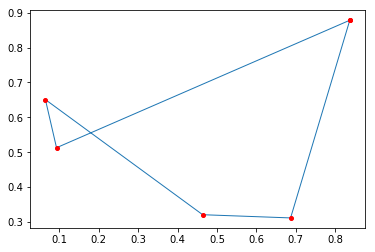

C: 2.52450898474


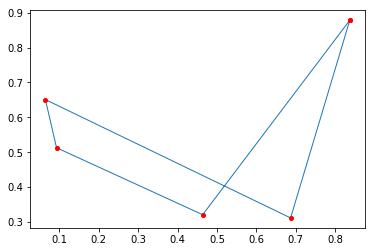

In [16]:
%matplotlib inline

npoints = 5
points = np.random.rand(npoints, 2)
tour = np.append(np.arange(points.shape[0]), 0)
print("C:", distance_cost(points, tour))
x, y = points[tour, 0], points[tour, 1]
plt.plot(x, y, 'o-', linewidth=1, markersize=4, markerfacecolor='red', markeredgecolor='red')
plt.show()

tour = greedy_optimization(points, distance_cost)
print("C:", distance_cost(points, tour))

x, y = points[tour, 0], points[tour, 1]
plt.plot(x, y, 'o-', linewidth=1, markersize=4, markerfacecolor='red', markeredgecolor='red');

2.85855581675


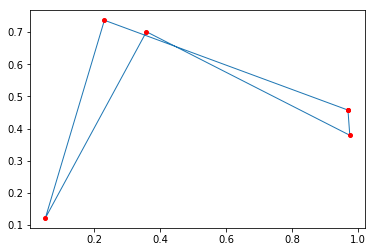

2.46666201438


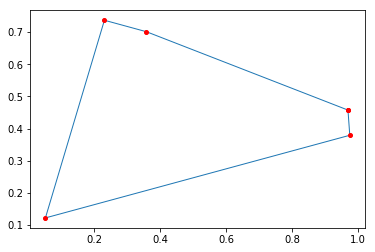

In [17]:
%matplotlib inline

npoints = 5
points = np.random.rand(npoints, 2)
tour = np.append(np.arange(points.shape[0]), 0)
print(distance_cost(points, tour))
x, y = points[tour, 0], points[tour, 1]
plt.plot(x, y, 'o-', linewidth=1, markersize=4, markerfacecolor='red', markeredgecolor='red')
plt.show()

tour = simulated_annealing_optimization(points, distance_cost)
print(distance_cost(points, tour))

x, y = points[tour, 0], points[tour, 1]
plt.plot(x, y, 'o-', linewidth=1, markersize=4, markerfacecolor='red', markeredgecolor='red');

In [18]:
npoints = 5
points = np.random.rand(npoints, 2)

%timeit branch_and_bound_path_optimization(points, distance_cost)
%timeit brute_force_path_optimization(points, distance_cost)
%timeit greedy_optimization(points, distance_cost)
%timeit simulated_annealing_optimization(points, distance_cost)

2.23 ms ± 3.79 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.1 ms ± 126 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
471 µs ± 439 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
85.2 ms ± 368 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Animations and Figures

In [19]:
def update_line(data, line):
    '''
    Method which updates a single line for animations.
    
    Params:
        data - (array-like) data for a single line. Must be uniform in size.
        line - (object) line object to modify
    Returns:
        line - (object) line object to plot
    '''
    line.set_data(data[:, 0], data[:, 1])
    return line,

def data_gen():
    '''
    Generator. Depends on global variable called 'data'. Meant for animations.
    '''
    for d in data[1:]:
        yield d

def generate_plot_object(data, title):
    #Source: https://matplotlib.org/examples/animation/simple_3danim.html
    fig, ax = plt.subplots()
    line, = ax.plot(data[0, :, 0], data[0, :, 1], 'o-', linewidth=1, markersize=4, markerfacecolor='red', markeredgecolor='red')

    # Setting the axes properties
    ax.set_xlim(0, 1)
    ax.set_xlabel('X')

    ax.set_ylim(0, 1)
    ax.set_ylabel('Y')

    ax.set_title(title)
    
    return fig, line

def generate_four_panel_plot(data, font_size=22):
    '''
    Quick plot function for 4-panel to showcase different stages of the travelling 
    salesman problem animations.
    
    Params:
        positions - (float) Time, or number of steps, at current iteration
    ''' 
    frame1 = data[0]
    frame2 = data[len(data)//4]
    frame3 = data[(3*len(data))//4]
    frame4 = data[-1]
    
    f,ax = plt.subplots(2,2, figsize=(12,8))
    
    ax[0, 0].plot(frame1[:, 0], frame1[:, 1], 'o-', linewidth=1, markersize=4, markerfacecolor='red', markeredgecolor='red')
    ax[0, 0].set_xlabel("X", fontsize=font_size)
    ax[0, 0].set_ylabel("Y", fontsize=font_size)
    ax[0, 0].set_title('Initial State', fontsize=font_size)
    
    ax[0, 1].plot(frame2[:, 0], frame2[:, 1], 'o-', linewidth=1, markersize=4, markerfacecolor='red', markeredgecolor='red')
    ax[0, 1].set_xlabel("X", fontsize=font_size)
    ax[0, 1].set_ylabel("Y", fontsize=font_size)
    ax[0, 1].set_title('Just Started', fontsize=font_size)
    
    ax[1, 0].plot(frame3[:, 0], frame3[:, 1], 'o-', linewidth=1, markersize=4, markerfacecolor='red', markeredgecolor='red')
    ax[1, 0].set_xlabel("X", fontsize=font_size)
    ax[1, 0].set_ylabel("Y", fontsize=font_size)
    ax[1, 0].set_title('Nearly Completed', fontsize=font_size)
    
    ax[1, 1].plot(frame4[:, 0], frame4[:, 1], 'o-', linewidth=1, markersize=4, markerfacecolor='red', markeredgecolor='red')
    ax[1, 1].set_xlabel("X", fontsize=font_size)
    ax[1, 1].set_ylabel("Y", fontsize=font_size)
    ax[1, 1].set_title('Returned Solution', fontsize=font_size)
    
    plt.tight_layout()
    return

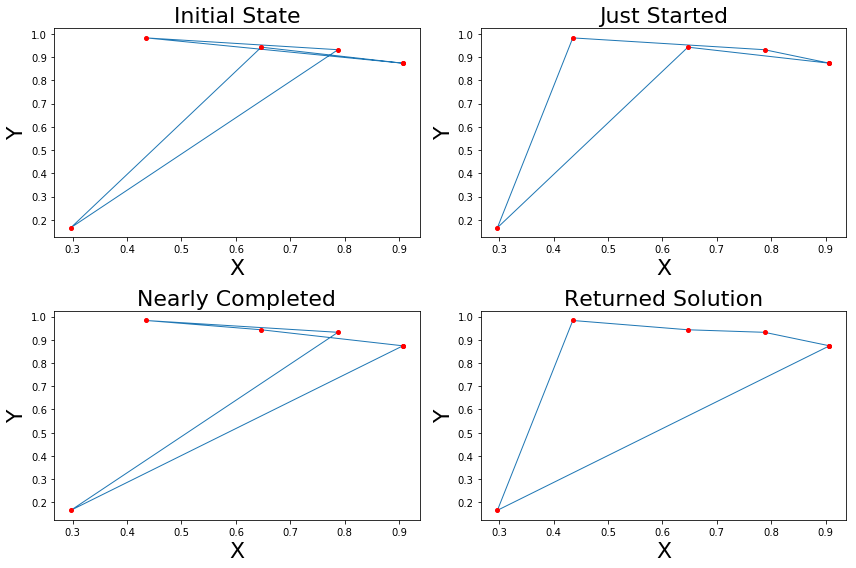

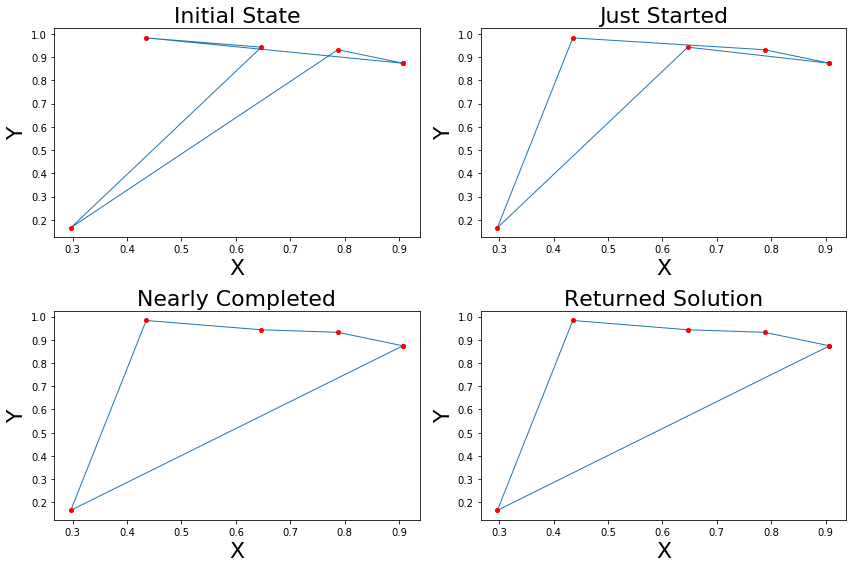

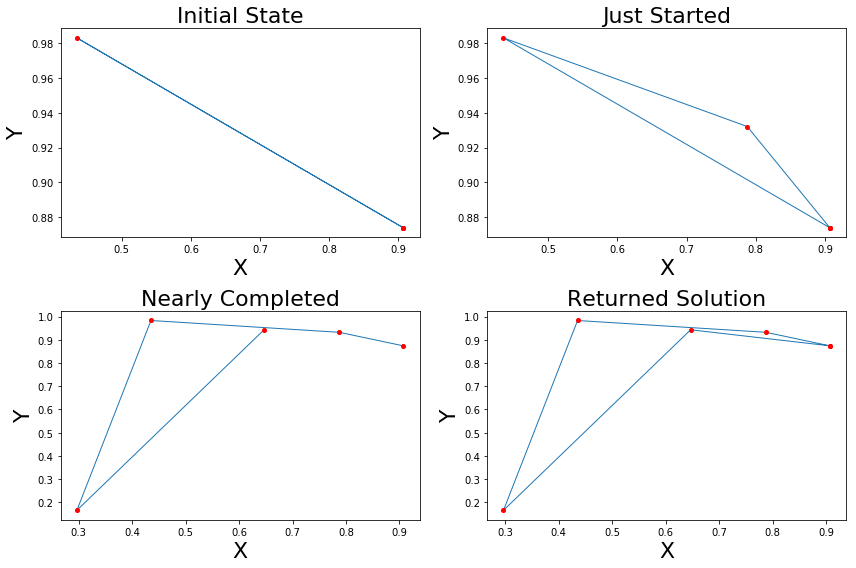

In [20]:
%matplotlib inline
npoints = 5
points = np.random.rand(npoints, 2)

tour, bf_data = brute_force_path_optimization(points, distance_cost, verbose=True)
bf_data.append(points[tour])
generate_four_panel_plot(bf_data)

tour, sa_data = simulated_annealing_optimization(points, distance_cost, nsteps=20, verbose=True)
sa_data.append(points[tour])
generate_four_panel_plot(sa_data)

tour, g_data = greedy_optimization(points, distance_cost, verbose=True)
generate_four_panel_plot(g_data)



<IPython.core.display.Javascript object>


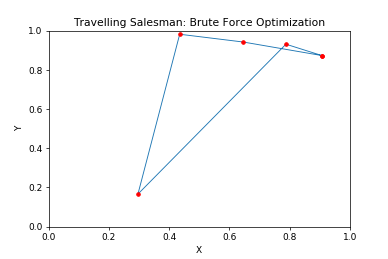

In [24]:
# Calls twice here because of this known bug: https://github.com/ipython/ipython/issues/10873
%matplotlib notebook
%matplotlib notebook

fig, line = generate_plot_object(np.array(bf_data), 'Travelling Salesman: Brute Force Optimization')
data = bf_data
bf_ani = animation.FuncAnimation(fig, update_line, data_gen, fargs=(line,), interval=300, repeat_delay=500)

if libraries_installed: bf_ani.save('brute-force.mp4', fps=2, extra_args=['-vcodec', 'libx264'])

<IPython.core.display.Javascript object>


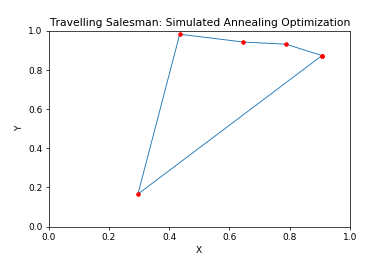

In [25]:
# Calls twice here because of this known bug: https://github.com/ipython/ipython/issues/10873
# If it still doesn't work properly, just try refreshing
%matplotlib notebook
%matplotlib notebook


fig, line = generate_plot_object(np.array(sa_data), 'Travelling Salesman: Simulated Annealing Optimization')
data = sa_data
sa_ani = animation.FuncAnimation(fig, update_line, data_gen, fargs=(line,), interval=300, repeat_delay=500)

if libraries_installed: sa_ani.save('simulated-annealing.mp4', fps=2, extra_args=['-vcodec', 'libx264'])

<IPython.core.display.Javascript object>


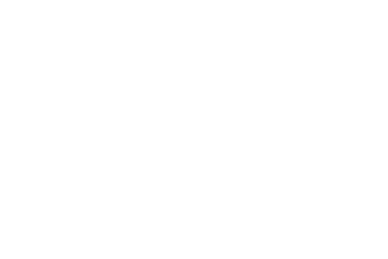

<IPython.core.display.Javascript object>


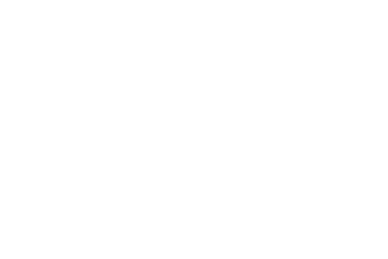

In [23]:
# Calls twice here because of this known bug: https://github.com/ipython/ipython/issues/10873
%matplotlib notebook
%matplotlib notebook

def generate_plot_object_custom(data):
    '''
    This method is needed because for whatever reason, the array accesses for
    the first line creation weren't working specifically for the greedy algorithm.
    '''
    fig, ax = plt.subplots()
    line, = ax.plot(data[0][:, 0], data[0][:, 1], 'o-', linewidth=1, markersize=4, markerfacecolor='red', markeredgecolor='red')

    # Setting the axes properties
    ax.set_xlim(0, 1)
    ax.set_xlabel('X')

    ax.set_ylim(0, 1)
    ax.set_ylabel('Y')

    ax.set_title('Travelling Salesman: Greedy Optimization')
    
    return fig, line

fig, line = generate_plot_object_custom(np.array(g_data))
data = g_data
greedy_ani = animation.FuncAnimation(fig, update_line, data_gen, fargs=(line,), interval=300, repeat_delay=500)

if libraries_installed: greedy_ani.save('greedy.mp4', fps=2, extra_args=['-vcodec', 'libx264'])